# Second practical exercise: Grid World and Value iteration

# A deterministic grid world

Finite grid with some obstacles inside. The agent can move up, left, right and down.

![](imgs/grid_world.png)

In [44]:
%pip install gymnasium

In [45]:
#import
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random

#EDIT: Damiano Imola
import matplotlib.pyplot as plt

In [46]:

# custom 2d grid world enviroment
class GridWorld(gym.Env):
    metadata = {'render.modes': ['console']}


    # actions available
    UP = 0
    LEFT = 1
    DOWN = 2
    RIGHT = 3


    def __init__(self, width, height):
        super(GridWorld, self).__init__()
        self.ACTION_NAMES = ["UP", "LEFT", "DOWN", "RIGHT"]
        self.num_actions = 4

        self.size = width * height  # size of the grid world
        self.num_states = self.size
        self.width = width
        self.height = height
        self.num_obstacles = int((width+height)/2)
        self.end_state = np.array([height - 1, width - 1], dtype=np.uint8) # goal state = bottom right cell

        # actions of agents : up, down, left and right
        self.action_space = spaces.Discrete(4)
        # observation : cell indices in the grid
        self.observation_space = spaces.MultiDiscrete([self.height, self.width])

        self.obstacles = np.zeros((height, width))

        for i in range(self.num_obstacles):
            obstacle = random.randrange(height) , random.randrange(width)
            while obstacle == (0, 0):
                obstacle = random.randrange(height), random.randrange(width)
            self.obstacles[obstacle] = 1

        self.num_steps = 0
        self.max_steps = height*width*2

        self.current_state = np.zeros((2), np.uint8)#init state = [0,0]

        self.directions = np.array([
            [-1,0], #UP
            [0,-1], #LEFT
            [1,0], #DOWN
            [0,1] #RIGHT
        ])

    def step(self, action):
        s_prime = self.transition_function(self.current_state, action)
        reward = self.reward_function(s_prime)
        terminated, truncated = self.termination_condition(s_prime)

        self.current_state = s_prime
        self.num_steps += 1

        return self.current_state, reward, terminated, truncated, None


    def transition_function(self, s, a):
        s_prime = s + self.directions[a]

        if s_prime[0] < self.height and s_prime[1] < self.width and s_prime[0] >= 0 and s_prime[1] >= 0:
          if self.obstacles[s_prime[0], s_prime[1]] == 1:
            return s
        else:
          return s

        return s_prime


    def reward_function(self, s):
        r = 0
        if s[0] == self.end_state[0] and s[1] == self.end_state[1]:
          r += 10

        return r

    def termination_condition(self, s):
        truncated = self.num_steps >= self.max_steps
        terminated = s[0] == self.end_state[0] and s[1] == self.end_state[1]

        return terminated, truncated

    def reset(self):
        self.current_state = np.zeros((2), np.uint8)
        self.num_steps = 0

        return self.current_state




    #EDIT: Damiano Imola
    def render(self):
        grid = np.zeros((self.height, self.width, 3), dtype=np.uint8) # the '3' is for the RGB channels

        row = self.current_state[0]
        col = self.current_state[1]

        for r in range(self.height): # iterating over rows
            for c in range(self.width): # iterating over columns
                if r == row and c == col:
                    grid[r, c] = [0, 0, 255]  # blue for player
                elif r == self.end_state[0] and c == self.end_state[1]:
                    grid[r, c] = [0, 255, 0]  # green for goal
                elif self.obstacles[r][c] == 1:
                    grid[r, c] = [128, 128, 128]  # gray for obstacles

        plt.figure(figsize=(self.width * 0.5, self.height * 0.5)) # the 0.5 is to scale a bit the image (you can adjust it as you whish)
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

Simulate all the four actions

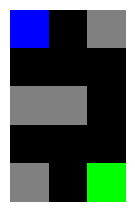

UP


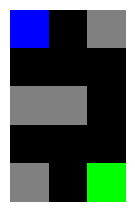

LEFT


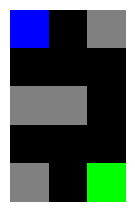

DOWN


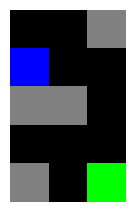

RIGHT


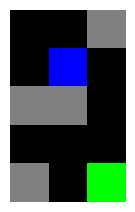

In [53]:
env = GridWorld(3,5)
env.reset()
env.render()

action_sequence = [0,1,2,3]

for a in action_sequence:
    print(env.ACTION_NAMES[a])
    env.step(a)
    env.render()

Simulate a random episode

LEFT


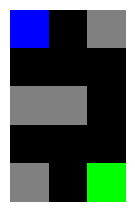

RIGHT


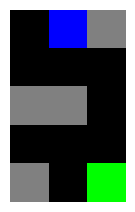

LEFT


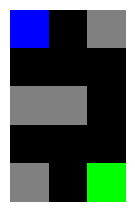

DOWN


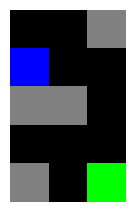

UP


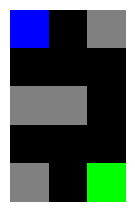

UP


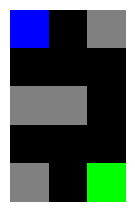

UP


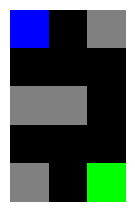

DOWN


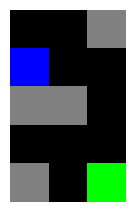

LEFT


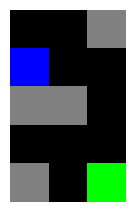

RIGHT


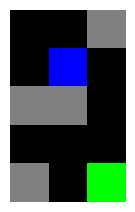

DOWN


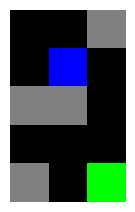

LEFT


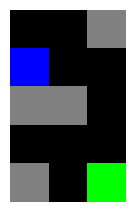

LEFT


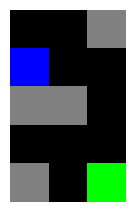

DOWN


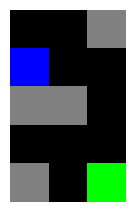

RIGHT


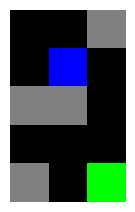

RIGHT


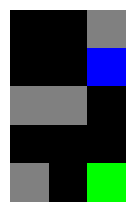

LEFT


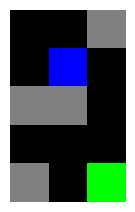

LEFT


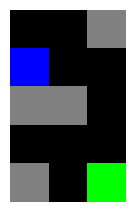

RIGHT


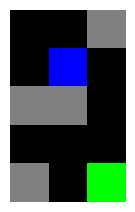

LEFT


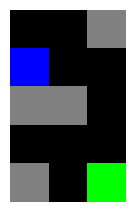

RIGHT


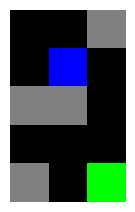

RIGHT


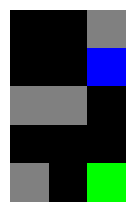

DOWN


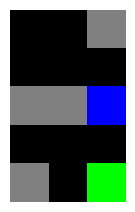

UP


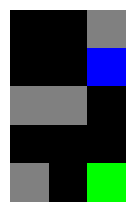

DOWN


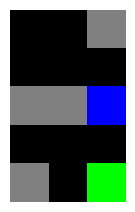

DOWN


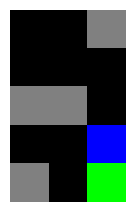

DOWN


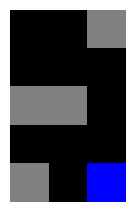

In [57]:
done = False
env.reset()
while not done:
    action = env.action_space.sample()
    print(env.ACTION_NAMES[action])
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()


## A non deterministic grid world

The agent goes with probability p to the right cell, with probability 1 - p in a different cell

In [49]:
class NonDeterministicGridWorld(GridWorld):
    def __init__(self, width, height, p=0.8):
        super(NonDeterministicGridWorld, self).__init__(width, height)
        self.probability_right_action = p

    def transition_function(self, s, a):
        s_prime = s + self.directions[a, :]

        #with probability 1 - p diagonal movement
        if random.random() <= 1 - self.probability_right_action:
            if random.random() < 0.5:
                s_prime = s_prime + self.directions[(a+1)%self.num_actions, :]
            else:
                s_prime = s_prime + self.directions[(a-1)%self.num_actions, :]


        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                return s_prime

        return s


Simulate a random episode

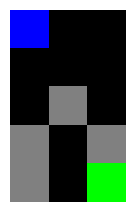

In [50]:
env = NonDeterministicGridWorld(3,5)
env.reset()
env.render()

LEFT


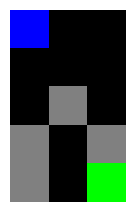

LEFT


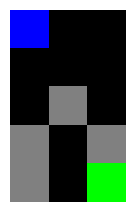

LEFT


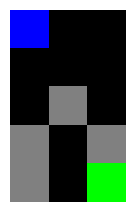

UP


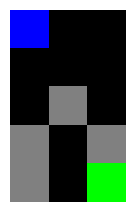

LEFT


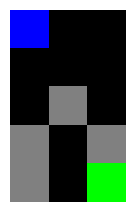

RIGHT


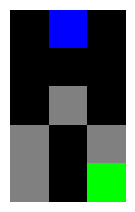

LEFT


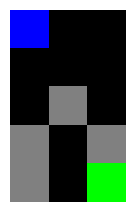

UP


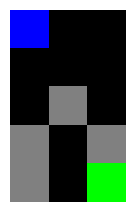

DOWN


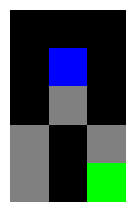

LEFT


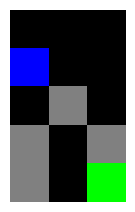

DOWN


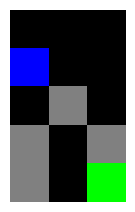

DOWN


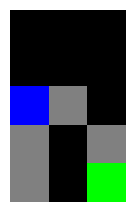

DOWN


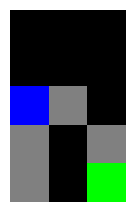

DOWN


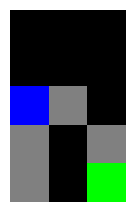

LEFT


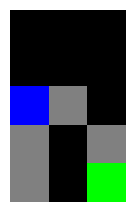

UP


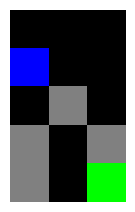

LEFT


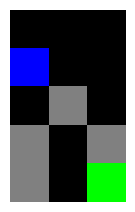

UP


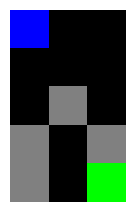

LEFT


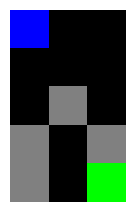

UP


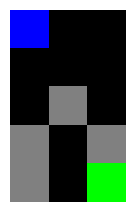

DOWN


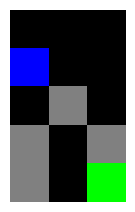

RIGHT


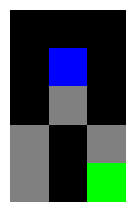

RIGHT


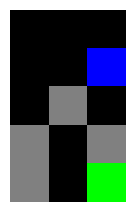

RIGHT


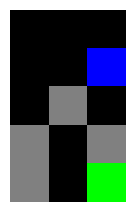

LEFT


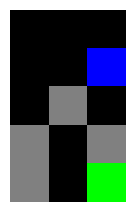

RIGHT


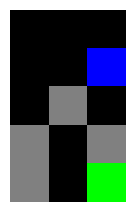

DOWN


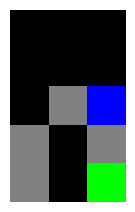

UP


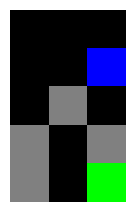

UP


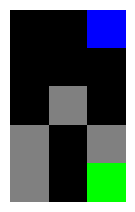

RIGHT


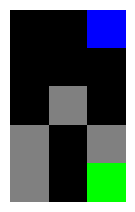

UP


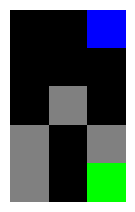

In [51]:
done = False
while not done:
    action = env.action_space.sample()
    print(env.ACTION_NAMES[action])
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()